## Impact of covid-19 on environment and economic activities

Covid-19 lockdown started from Mar 24, 2020 - May 30, 2020. During this period, there was negligible human movement. This had a trickle down effect on economic activities and by virtual of which there was a presumption that air quality would've improved around this timeframe.

We analyse this hypothesis by analyzing the air quality of Bengaluru as a case study using ground measurements and space-based satellite data to test our hypothesis.


### Air Quality Index

In [49]:
# Collect all the data from the CPCB website and save it to as a csv file
# The data is stored in assets folder `grd_aqi` which contains the following air quality parameters for the year 2019-2021
# PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone
# Using this data, we can calculate the air quality index for each ground station, for every year.
# In this analysis, we downloaded data for silk-board station in bangalore. 

import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import seaborn as sns
import xarray as xr
sns.set_style("white")

In [22]:

# preprocessing functions


def formatdf(df) -> pd.DataFrame:
    """
    format CPCB excel files to a dataframe
    """
        
    dfa = df.loc[df.iloc[:, 0] == "From Date"]
    df = df.iloc[dfa.index[0] :, :]
    df, df.columns = df[1:], df.iloc[0]
    df = df.drop("To Date", axis=1)
    dfc = df.loc[dfa.index[1] :].copy()
    dfc, dfc.columns = dfc[1:], dfc.iloc[0]
    dfc = dfc.dropna(axis=1, how="all")
    dfd = df.loc[df.iloc[:, 0].isnull() == True].index[0]
    dfe = df.loc[: dfd - 1]
    dff = dfe.merge(dfc, on="From Date", how="outer")
    dff["_index"] = pd.to_datetime(dff["From Date"], format="%d-%m-%Y %H:%M")
    dff = dff.replace({"None": np.nan})
    dff = dff.dropna(axis =1, how="all")
    dff = dff.drop("From Date", axis=1)
    return dff

# sub-index values for each paramter to calc AQI
# Adopted from https://bit.ly/3KtArlX
atm = {
    "PM2.5": [30, 60, 90, 120, 250],
    "PM10": [50, 100, 250, 350, 430],
    "NO2": [40, 80, 180, 280, 400],
    "NH3": [200, 400, 800, 1200, 1800],
    "NOx": [40, 80, 180, 280, 400],
    "Ozone": [50, 100, 168, 208, 748],
    "CO": [1, 2, 10, 17, 34],
    "SO2": [40, 80, 380, 800, 1600],
}

def roundoff(func):
    def wrapper(*args, **kwargs):
        return np.rint(func(*args, **kwargs))

    return wrapper

@roundoff
def sub_index(a, b):
    if a <= b[0]:
        return a * 50 / b[0]
    elif a > b[0] and a <= b[1]:
        return 50 + (a - b[0]) * 50 / (b[1] - b[0])
    elif a > b[1] and a <= b[2]:
        return 100 + (a - b[1]) * 100 / (b[2] - b[1])
    elif a > b[2] and a <= b[3]:
        return 200 + (a - b[2]) * 100 / (b[3] - b[2])
    elif a > b[3] and a <= b[4]:
        return 300 + (a - b[3]) * 100 / (b[4] - b[3])
    elif a > b[4]:
        return 400 + (a - b[4]) * 100 / (b[4] - b[3])
    else:
        return np.nan


def aqi(row, column_list):
    mylist = [sub_index(row[i], atm[i]) for i in column_list if i != "NO"]
    return max(mylist)


In [3]:
# air quality ground station
path_grd_aqi = os.path.join(os.pardir, 'assets', 'grd_aqi')

c_df = [formatdf(pd.read_excel(i)) for i in glob.glob(os.path.join(path_grd_aqi, "*.xlsx"))]
df_aqi = pd.concat(c_df).set_index("_index")
column_list = df_aqi.columns
df_aqi["AQI"] = df_aqi.apply(lambda row: aqi(row, column_list), axis=1)
df_aqi.index.name = None
df_aqi["mm-dd"] = df_aqi.index.strftime("%m-%d")

In [48]:
# df_aqi.describe(), df_aqi.isna().sum().values, df_aqi.dropna().shape, df_aqi.shape
df_desc = df_aqi.describe()
df_desc.loc['dtype'] = df_aqi.dtypes
df_desc.loc['size'] = len(df_aqi)
df_desc.loc['count_sum'] = df_aqi.isnull().sum()
df_desc
# we do not remove any data are anomalies since AQI can fluctuate for various reasons (noticeably, fires, large crowd gathering etc)
# we also notice that there are variable number of missing values in the data, which we can be removed later in the analysis.

,PM2.5,PM10,NO,NO2,NOx,NH3,SO2,CO,Ozone,AQI
count,523.0,523.0,518.0,522.0,522.0,522.0,517.0,522.0,523.0,523.0
mean,33.186711,81.826979,11.013494,33.408448,26.628736,12.933372,4.399246,0.809808,42.657572,81.940727
std,15.021592,30.589529,18.618106,20.251314,22.255662,5.493638,2.611636,0.392014,16.600392,27.48058
min,4.63,18.65,0.35,2.68,1.7,1.71,1.04,0.17,13.51,29.0
25%,20.82,57.155,1.2425,18.27,12.495,9.16,2.69,0.53,31.765,59.0
50%,33.98,81.79,5.67,31.805,20.29,13.69,3.52,0.68,37.29,82.0
75%,43.865,101.295,11.0325,43.92,31.955,16.6775,5.6,1.02,51.745,102.0
max,78.6,197.88,171.71,115.35,198.09,28.31,18.01,2.55,106.56,218.0
dtype,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
size,544,544,544,544,544,544,544,544,544,544


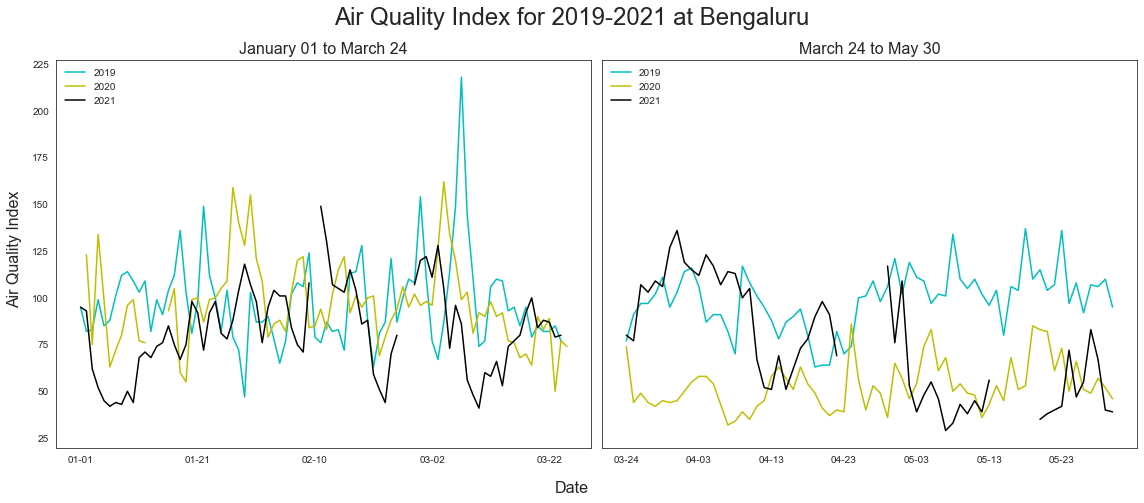

In [39]:
# plot comparing air quality over the years (pre-covid months and otherwise)
fig, ax = plt.subplots(1,2, figsize = (16, 7), sharey= True)

years = [2019, 2020, 2021]
for year, scolor in zip(years, 'cyk'):
  df_aqi.loc[f'{year}-01-01': f'{year}-03-24'].plot(  x= 'mm-dd', y='AQI', ax=ax[0],c = scolor, legend= None, label = f'{year}', )
  df_aqi.loc[f'{year}-03-24': f'{year}-05-30'].plot(  x= 'mm-dd', y='AQI', ax=ax[1],c = scolor, legend = None, label = f'{year}')
  _ = ax[0].set_title(f'January 01 to March 24',fontsize = 16)
  _ = ax[1].set_title(f'March 24 to May 30', fontsize = 16)
  _ = ax[0].legend(loc='upper left', frameon=False)
  _ = ax[1].legend(loc='upper left', frameon=False)
  ax[0].xaxis.label.set_visible(False)
  ax[1].xaxis.label.set_visible(False)
fig.supylabel('Air Quality Index', x=0.01, fontsize=16)
fig.suptitle('Air Quality Index for 2019-2021 at Bengaluru', fontsize = 24)
fig.supxlabel('Date', fontsize=16)
plt.tight_layout()

In the above graph we are trying to visualise AQI for pre-covid months and during-covid months. We notice a sharp drop all along in AQI for the year 2020 in during-covid months.
The line is discontinues as the data for that date is unavailable for that station.

In [51]:
# A sudden rise can be attributed to fires, large crowd gathering, storm etc. While a sudden drop can be due to precipitation etc
# We try to control for rainfall to avoid sudden drops in AQI. We do this to avoid any bias in our comparison over the years

# Rainfall data is downloaded from CHIRPS daily data at resolution of 0.05 degree (https://chc.ucsb.edu/data/chirps)

# We write a bash script to download the data from the CHIRPS website and save it to the `tmp` folder.
# Later we will use the `tmp` folder to read the data and convert it to a csv and save it in `assets` folder

# bash files is saved as `df_rainfall.sh`
# python file to save as csv is titled as `df_rainfall.py`


In [59]:
# raed rainfall data
path_chirps = os.path.join(os.pardir, 'assets', 'rainfall')
c_df = [pd.read_csv(i, parse_dates=['time'] ).set_index("time") for i in glob.glob(os.path.join(path_chirps,"./*.csv"))]
df_rainfall = pd.concat(c_df) 

In [69]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison


class StatisticalTest:
    """
    param: parameter which needs to be tested (statistically)
    sigLevel: significance level for analysis
    
    =========================================
    This class is used to perform statistical test
    we perform one-way anova for 2019-2021 data
    if the p-value is less than the significance level, 
    we reject the null hypothesis, and perform tukey test
    =========================================
    """
    
    def __init__(self, param, sigLevel=0.01) -> None:
        self.param = param
        self.sigLevel = sigLevel

    def printer(self, anova_table):
        print("=" * 50)
        print(anova_table)
        print("=" * 50)
        if anova_table.loc["year_class", "PR(>F)"] < self.sigLevel:
            return True
        print("Results not significant. Accept null hypothesis!")
        return False

    def anova_test(self, df):
        # Ordinary Least Squares (OLS) model
        # compute F statistic and perform one-way anova for all three years
        df = df.dropna(subset=[self.param, "year_class"])
        model = ols(f"{self.param} ~ year_class", data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=1)
        return self.printer(anova_table)

    def tukey_test(self, df):
        # if null hypothesis is rejected, perform pairwise tukey-hsd
        anova_bool = self.anova_test(df)
        if anova_bool:
            df = df.dropna(subset=["year_class", self.param])
            mc = MultiComparison(df[self.param], df["year_class"])
            print(mc.tukeyhsd(self.sigLevel).summary())

            return None

        return None

In [75]:
# Join rainfall and ground station air quality data
df_join = df_rainfall.join(df_aqi, how = "inner")
df_join.loc[:,"precip_past"] = df_join["precip"].shift(1)

#exclude precipitation with more than 5 mm rain
df_join = df_join.loc[(df_join.precip < 5) & (df_join.precip_past < 5)]

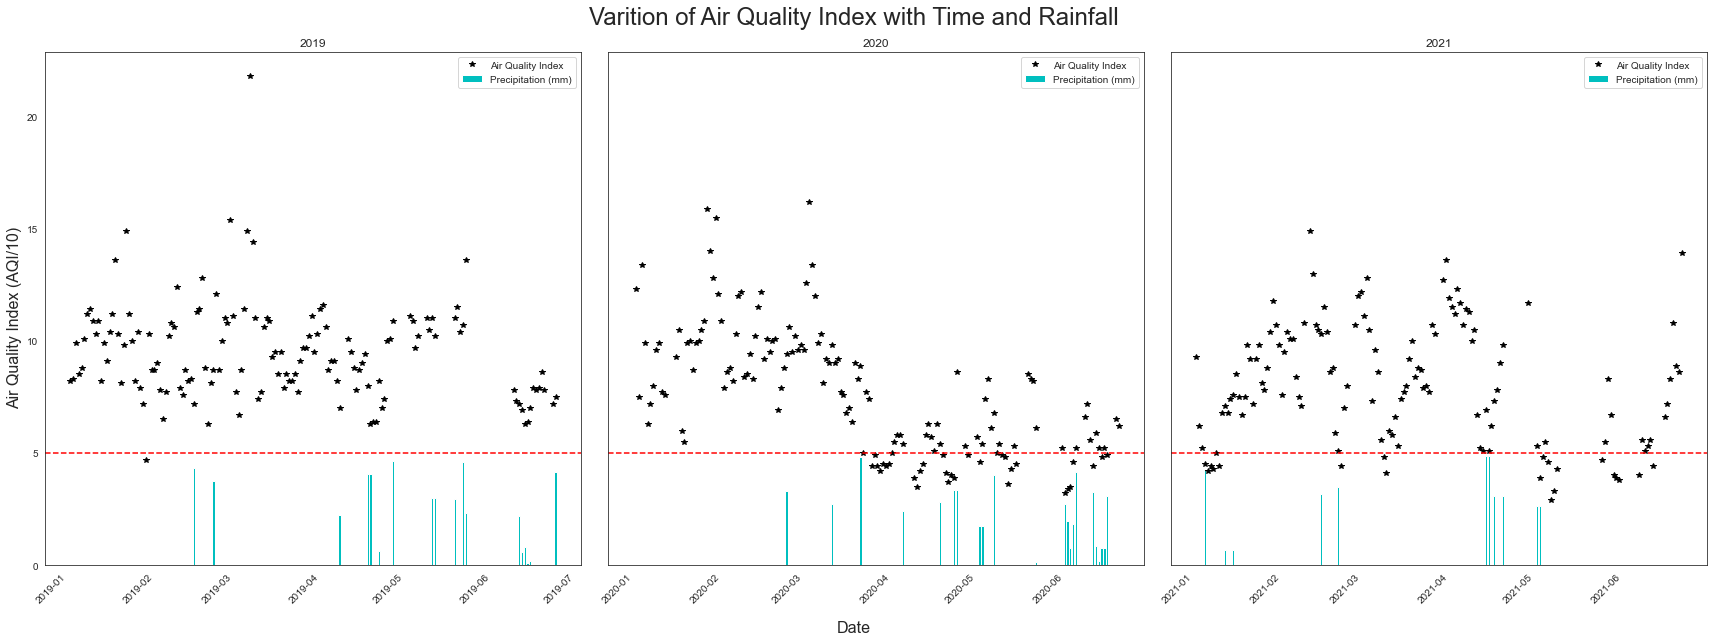

In [77]:
fig, axe = plt.subplots(1,3, figsize = (24, 9), sharey= True,)
for year, axs in zip([2019, 2020, 2021], axe):
  axs.bar(df_join.loc[ f'{year}-01-01': f'{year}-06-24'].index.values, df_join.loc[ f'{year}-01-01': f'{year}-06-24'].precip.values, color='c', label = 'Precipitation (mm)')
  axs.plot(df_join.loc[ f'{year}-01-01': f'{year}-06-24'].index.values, df_join.loc[ f'{year}-01-01': f'{year}-06-24', 'AQI'].values/10, color='k', label = 'Air Quality Index',  linestyle="",marker="*")
  axs.legend()
  axs.axhline(5, color='r', ls = '--')
  axs.set_title(year)
fig.autofmt_xdate(rotation=45)
fig.suptitle('Varition of Air Quality Index with Time and Rainfall', fontsize=24)
fig.supxlabel('Date', fontsize=16)
fig.supylabel('Air Quality Index (AQI/10)', fontsize=16, x = 0.01 )
plt.tight_layout()

The above figure illustrates the effect of rainfall on Air Quality Index. The y-axis is scaled by 10.
We notice that immedeatly after a heavy rainfall, the AQI drops. This causal effect can lead to biased estimation since, we aim to measure only AQI with other factor constant. 
Thus to control for this, we exclude AQI measurements which are higher than 5 mm/day for performing analysis


In [78]:
# AQI statistical test
sigLevel = 0.01 # significance level

# add unique id for statistical analysis
for year in [2019, 2020, 2021]:
    df_join.loc[f"{year}-03-24":f"{year}-05-30", "year_class"] = str(year)


for param in ["AQI"]:
    print(f"statistical analyis for param: {param}")
    myobj = StatisticalTest(param, sigLevel)
    myobj.tukey_test(df_join)

statistical analyis for param: AQI
               df        sum_sq       mean_sq          F        PR(>F)
year_class    2.0  42034.750350  21017.375175  47.592059  2.419127e-16
Residual    134.0  59176.432131    441.615165        NaN           NaN
 Multiple Comparison of Means - Tukey HSD, FWER=0.01  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
  2019   2020 -41.4913    0.0  -54.216 -28.7666   True
  2019   2021 -16.3669 0.0012 -29.7441  -2.9897   True
  2020   2021  25.1244    0.0  12.0018   38.247   True
------------------------------------------------------


From the analysis we can say with surety that there was a significant difference in AQI for all pair of years. More so in 2019-2020.
Thus we reject null hypothesis and accept the alternative. 

### comparison of Tropospheric NO2 and AQI

Data for tropospheric NO2 (sentinel 5p) is downloaded earth engine, code for which is in `src/dl_s5p_no2.py`


the downloaded csv is a time-series for Bengaluru region with single statistic `mean`. 

In [80]:
# function to read the data from the csv file
def formatter(filepath):
    df = pd.read_csv(filepath)
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
    df = df.drop(["system:index", ".geo"], axis=1)
    df["tropospheric_NO2_column_number_density"] = (
        df["tropospheric_NO2_column_number_density"] * 1e6
    )
    df.rename(columns={"tropospheric_NO2_column_number_density": "T_NO2"}, inplace=True)
    df = df.set_index("date")
    df["mm-dd"] = df.index.strftime("%m-%d")
    return df

# read ground aqi data
path_assets = os.path.join(os.pardir, "assets", "sat_no2_blr")

# read all files in the directory for no2
c_df = [formatter(i) for i in glob.glob(os.path.join(path_assets, "*.csv"))]
df_no2 = pd.concat(c_df)

# Join rainfall and satellite NO2 data; remove high intensity rainfall
df_merge = df_rainfall.join(df_no2, how="inner")
df_merge['precip_past'] = df_merge['precip'].shift(1)
df_merge = df_merge.loc[(df_merge.precip < 5) & (df_merge.precip_past < 5)]

In [81]:
sigLevel = 0.01
# unique column `year class` to assign values to during covid period
for year in [2019, 2020, 2021]:
    df_merge.loc[f"{year}-03-24":f"{year}-05-30", "year_class"] = str(year)

for param in ["T_NO2"]:
    print(f"statistical analyis for param: {param}")
    myobj = StatisticalTest(param, sigLevel)
    myobj.tukey_test(df_merge)


statistical analyis for param: T_NO2
               df        sum_sq       mean_sq          F        PR(>F)
year_class    2.0  38775.676627  19387.838314  87.752307  3.827678e-25
Residual    135.0  29826.659262    220.938217        NaN           NaN
 Multiple Comparison of Means - Tukey HSD, FWER=0.01  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
  2019   2020 -39.7346   -0.0 -48.7737 -30.6955   True
  2019   2021 -26.2402    0.0 -35.4893 -16.9911   True
  2020   2021  13.4944 0.0001   4.1989  22.7899   True
------------------------------------------------------


Here again we see that the difference in mean between each pair of years in the timeframe is significant. Let us know compare ground measurements with satellite data

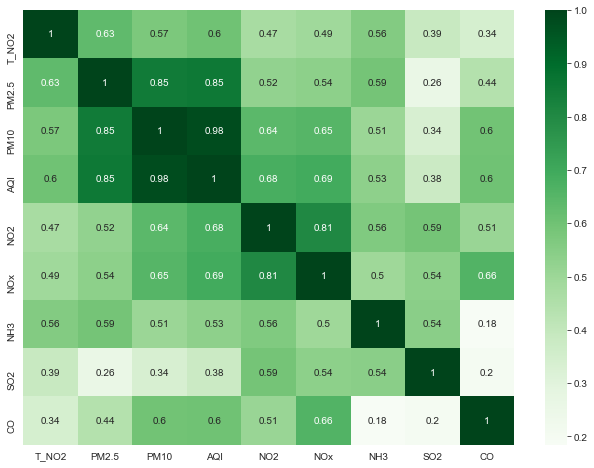

In [86]:

corr_test = df_no2.join(df_aqi, how='inner', lsuffix='_')
corr_res = corr_test[['T_NO2', 'PM2.5', "PM10", 'AQI', "NO2" ,"NOx", 	"NH3", 	"SO2", 'CO']].corr()

plt.figure(figsize=(11,8))
sns.heatmap(corr_res, cmap="Greens",annot=True)
plt.show()

We notice that there is moderate to high correlation between ground and satellite measurements.  

Now that we have confirmed the drop in AQI during lockdown, we now look for effects of such a drop. Starting with Air temperature and land, we look into variability for the above said time period and perform statistical analysis

# Impact of drop in AQI on Air and Land Temperature